In [1]:
#!pip install gym
#!pip install tensorflow[and-cuda]
#!pip install pygame

In [2]:
# set tf warning level to 2 ....shows errors but not warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
#tf.__version__

In [3]:
from gym import Env
from gym.spaces import Discrete, Box

import pandas as pd
import matplotlib.pyplot as plt


import tensorflow as tf
#tf.config.run_functions_eagerly(True)
#print(tf.config.functions_run_eagerly())
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten

# tyr legacy adam due to numpy error
from tensorflow.keras.optimizers import Adam
#from tensorflow.keras.optimizers.legacy import Adam

import numpy as np
import random
import os

import pygame


# get component class from custom module
from component_module import Component, plot_correlation_network, plot_component_comparison, getKDEDensity, getDistributionBins, kde_mutual_information, drop_static_columns, performFourierAndLimitHarmonics, scaler_sec_midnight, save_component, load_component, calculate_phase_and_time_difference

# Set the random seed
seed_value = 44
np.random.seed(seed_value)
random.seed(seed_value)

In [4]:
# Check if TensorFlow is built with CUDA support
if tf.config.list_physical_devices('GPU'):
    print("CUDA is available")
    print(f"Device: {tf.config.list_physical_devices('GPU')[0]}")
else:
    print("CUDA is not available")

CUDA is available
Device: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


I0000 00:00:1728064870.292070    8031 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728064870.332258    8031 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728064870.332519    8031 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


# Create Environment

In [5]:
# ubuntu
df_normalised = pd.read_csv("/home/loz/MSc/MSc_Project/SWaT_sec_minmax_22_comps.csv", index_col='time_in_seconds')

data_array = df_normalised.to_numpy()
#df_normalised.shape

In [6]:
#df_normalised

In [7]:
data_array[35].max()

1.0

In [8]:
component_pos = {key: idx for idx, key in enumerate(df_normalised.columns)}
#component_pos.items()

In [9]:
#data_array[component_pos['LIT101']]

In [10]:
#df_comp_files

In [11]:
#path = '/home/loz/Documents/GitHub/MSc-Project/final_code/component_objs/'
path = '/home/loz/MSc/MSc_Project/final_code/component_objs/'


df_comp_files = pd.read_csv(path + 'component_filenames.csv', index_col=0)
components = {}
for component_name, filename in df_comp_files['filename'].items():    
    # put returned component object into dict
    components[component_name] = load_component(filename)
    #print(filename)

Component 'FIT101' has been loaded from /home/loz/MSc/MSc_Project/final_code/component_objs/FIT101.
Component 'LIT101' has been loaded from /home/loz/MSc/MSc_Project/final_code/component_objs/LIT101.
Component 'MV101' has been loaded from /home/loz/MSc/MSc_Project/final_code/component_objs/MV101.
Component 'P101' has been loaded from /home/loz/MSc/MSc_Project/final_code/component_objs/P101.
Component 'P102' has been loaded from /home/loz/MSc/MSc_Project/final_code/component_objs/P102.
Component 'AIT201' has been loaded from /home/loz/MSc/MSc_Project/final_code/component_objs/AIT201.
Component 'AIT202' has been loaded from /home/loz/MSc/MSc_Project/final_code/component_objs/AIT202.
Component 'AIT203' has been loaded from /home/loz/MSc/MSc_Project/final_code/component_objs/AIT203.
Component 'FIT201' has been loaded from /home/loz/MSc/MSc_Project/final_code/component_objs/FIT201.
Component 'MV201' has been loaded from /home/loz/MSc/MSc_Project/final_code/component_objs/MV201.
Component 'P

In [12]:
#components['LIT101'].norm_step_size

In [13]:
# test lstm swat simulator
# Load the model from the SavedModel directory
# 20 secs
#swat_lstm = tf.keras.models.load_model('swat_lstm_1_0.keras')

# get single output model
swat_lstm = tf.keras.models.load_model('swat_lstm_lit101.keras')
model_window = 20

#swat_lstm = tf.keras.models.load_model('swat_lstm_100s.keras')
#model_window = 100



I0000 00:00:1728064870.638683    8031 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728064870.639086    8031 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728064870.639418    8031 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728064870.718886    8031 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

# Agent for single window

In [14]:
# Reshape the input from data_array to add the batch dimension
#reshaped_input = data_array[:model_window-1, :].reshape(1, model_window-1, data_array.shape[1])  # (1, 99, 37)
reshaped_input = data_array[:model_window-1, :].reshape(1, model_window-1, data_array.shape[1])  # (1, 19, 22)
# round to make observation space workable
#reshaped_input = np.round(reshaped_input, 2)


reshaped_input.shape
#reshaped_input[0,-1,]

(1, 19, 22)

# get last row
one_state = reshaped_input[0,-1,:]
one_state.shape

for _ in range(10):
    prediction = swat_lstm.predict(reshaped_input)
    # Print shape
    #print(prediction.shape)
    # drop first row from input, add prediction with new axis padded to match shape
    reshaped_input = np.concatenate((reshaped_input[:, 1:, :], prediction[:, np.newaxis, :]), axis=1)
    #print(reshaped_input.shape)


In [15]:
component_pos

{'P602': 0,
 'LIT301': 1,
 'MV201': 2,
 'FIT101': 3,
 'FIT502': 4,
 'MV101': 5,
 'MV304': 6,
 'P101': 7,
 'FIT301': 8,
 'P301': 9,
 'MV301': 10,
 'P302': 11,
 'MV303': 12,
 'FIT503': 13,
 'LIT401': 14,
 'FIT501': 15,
 'FIT504': 16,
 'P203': 17,
 'MV302': 18,
 'P205': 19,
 'FIT401': 20,
 'LIT101': 21}

In [34]:
def update_state(state_history, action_input):
    # reshape if needed
    if action_input.ndim == 1:
        action_input = action_input[np.newaxis, np.newaxis, :] 
    if action_input.ndim == 2:
        action_input = action_input[np.newaxis, :, :]  # Shape becomes (1, 1, 22)


    
    # add action to previous states
    model_input = np.concatenate((state_history[:, 1:, :], action_input), axis=1)
    # predict
    new_state = swat_lstm.predict(model_input)
    return new_state, model_input
    


In [35]:
reshaped_input[0,-1,:]

array([0.        , 0.00999836, 1.        , 0.        , 0.51885689,
       0.        , 0.        , 1.        , 0.93666145, 0.        ,
       0.        , 1.        , 0.        , 0.36842682, 0.18902553,
       0.56394729, 0.24369638, 1.        , 1.        , 0.        ,
       0.60121598, 0.9703925 ])

In [36]:
last_row = reshaped_input[0,-1,:].copy()

In [37]:
last_row[component_pos['LIT101']]

0.9703925017804363

In [38]:
last_row.shape

(22,)

In [43]:
action_input = last_row.copy()
action_input[component_pos['MV101']] = 0
action_input = action_input[np.newaxis, np.newaxis, :] 
action_input.ndim

3

In [44]:
reshaped_input.shape

(1, 19, 22)

In [45]:
new_state, model_input = update_state(reshaped_input, action_input) 
new_state

#new_state[0]=10
#new_state

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


array([[0.9714107]], dtype=float32)


def main():
    # Initialize pygame
    pygame.init()
    screen = pygame.display.set_mode((600, 400))
    pygame.display.set_caption("SWAT Environment Visualization")

    # Font for rendering text
    font = pygame.font.SysFont('Arial', 24)

    # Create the environment
    env = SwatEnv()

    # Initialize game loop variables
    running = True
    clock = pygame.time.Clock()

    state = env.reset()  # Initialize environment state

    while running:
        # Handle events
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False

        # Action logic (can be random for testing purposes)
        action = random.randint(0, 2)  # Replace with your agent's action

        # Perform step
        state, reward, done, info = env.step(action)

        # Render the environment
        env.render(screen, font)

        # Update the display
        pygame.display.flip()

        # End if the shower is done
        if done:
            state = env.reset()

        # Control frame rate (optional)
        clock.tick(30)  # 30 FPS

    pygame.quit()

if __name__ == "__main__":
    main()


In [ ]:
# sample from action space
#env.action_space.sample()

In [ ]:
#env.observation_space.sample()

In [ ]:
# shown as high precision but actually 2 dp....
#sampled_obs = env.observation_space.sample()
#sampled_obs_rnd = np.round(sampled_obs, 2)
#sampled_obs_rnd

print(env.state.shape)

env = SwatEnv(reshaped_input)# store lit101 values form each episode

lit101_dict = {}

episodes = 5
for episode in range(1, episodes+1):
    
    env.reset(reshaped_input)
    state = env.state
    done = False
    score = 0 
    
    while not done:
        #env.render()
        # sample from 4 possible states 
        #action = env.action_space.sample()
        
        # just activate MV101 to see if response from lstm model is linear
        action = 1
        
        
        # pass 1 x 37 array of SWat states
        #action = one_state
        #n_state, reward, done, info = env.step(action)
        n_state, reward, done = env.step(action)
        print(n_state)
        score+=reward
    print('Episode:{} Score:{}'.format(episode, score))
    # add this episodes list of values
    lit101_dict[episode] = env.lit101_value_record

for key, value in lit101_dict.items():
    plt.plot(value, label=key)

plt.legend()    
plt.show()

# Test with multiple start points

In [ ]:
#start_idxs = [np.random.randint(0, 1000) for n in range(5)]
#start_idxs

In [ ]:
data_array.shape

def run_random_trials(environment, data_array, window_size , episode_length, number_of_trials):
    ''' Function to set up each trial with a random window'''

    values_dict = {}
    input_windows = {}
    
    
    data_length = data_array.shape[0]
    window_size = model_window - 1
    
    values_dict = {}
    input_windows = {}
    
    
    for trial in range(number_of_trials):
    
        values_dict[trial] = run_trial(environment,episode_length, number_of_episodes=1)
        
    return values_dict, input_windows

# Q Learning Table Implementation

In [170]:
# inherit from gym env
class SwatEnv(Env):
    def __init__(self, data_array, window_size=19, episode_length=100):
        print('init reached')
        # 0: both off, 1: MV101 On MV201 Off, 2: MV101 Off MV201 On, 3: both on
        self.action_space = Discrete(4)
        self.episode_length = episode_length
        
        # make sure array is 3 dims for model input
        if len(data_array.shape) == 2:
            # Add a batch dimension to make it (1, time_steps, features)
            data_array = data_array[np.newaxis, :, :]
        
        # swat value array, only position 1 used as lit101 level. 2.d.p 
        self.observation_space = Box(
            # round to 2 d.p. to act as binning values
            low=np.round(np.full((1, 22), 0.00), 2),  # 1x37 array with all elements set to 0.00
            high=np.round(np.full((1, 22), 100.00), 2),  # 1x37 array with all elements set to 100.00
            dtype=np.float32  # Specify float with two decimal places precision
        )
        
        # Initialise data params
        self.data_array = data_array
        self.window_size = window_size 
        
        # use reset to intialise the data window to use 
        self.reset(data_array)      
        
        # state history is 98 time steps preceding
        #self.state_history = model_input
        # set start state as last row in modelinput
        #elf.state = self.state_history [0,-1,:]
        
        # set shower length
        self.episode_length = episode_length
        
        self.lit101_value_record = []
    
    # Override inherited method  
    def sample_observation(self):
        return np.round(self.observation_space.sample(), 2)

        
    def update_state(self, state_history, action_input):
        # Ensure action_input is reshaped to 1x22 array
        #action_input = action_input.reshape(1, -1)
        
        # add action to previous states
        #model_input = np.concatenate((state_history[:, 1:, :], action_input[:, np.newaxis, :]), axis=1)
        # reshape if needed
        if action_input.ndim == 1:
            action_input = action_input[np.newaxis, np.newaxis, :] 
        if action_input.ndim == 2:
            action_input = action_input[np.newaxis, :, :]  # Shape becomes (1, 1, 22)
    
        # add action to previous states
        model_input = np.concatenate((state_history[:, 1:, :], action_input), axis=1)
         
        
        # predict
        
        new_state = swat_lstm.predict(model_input)
        new_state = np.round(new_state, 2)
        
        # prob don't use as new window wanted
        # update history with new state
        #self.state_history = np.concatenate((state_history[:, 1:, :], new_state[:, np.newaxis, :]), axis=1)
        
        # flatten new_state from (1,37) to (37,)
        #new_state = new_state.flatten()
        #print(new_state)
        
        return new_state
    
        
    def step(self, action):
        #print(f'step reached {action}')
        
        # copy current state
        action_input = self.state.copy() 
        
        # MV101 
        if action == 0:
            ## MV101 and MV201 off         
            action_input[component_pos['MV101']] = 0
            action_input[component_pos['MV201']] = 0
            
        elif action == 1:
            # MV101 On, MV201 Off
            action_input[component_pos['MV101']] = 1
            action_input[component_pos['MV201']] = 0
        elif action == 2:
            # MV101 Off, MV201 On
            action_input[component_pos['MV101']] = 0
            action_input[component_pos['MV201']] = 1
        elif action == 3:
            # Both MV101 and MV201 On
            action_input[component_pos['MV101']] = 1
            action_input[component_pos['MV201']] = 1

        
        
        new_state = self.update_state(self.state_history, action_input)
        # test with no actions
        #new_state = self.update_state(self.state_history, self.state.copy())
        
        
        #print(new_state.shape, self.state.shape)
        
        #record lit101 state
        #self.lit101_value_record.append((np.round(new_state[component_pos['LIT101']], 2)))
        # get change in value for plotting
        
        # tuple of new and old lit
        self.lit101_value_record.append((np.round(new_state,2), np.round(self.state[component_pos['LIT101']], 2)))

                                     
        # check for increase
        if new_state > self.state[component_pos['LIT101']]:
            reward = new_state - self.state[component_pos['LIT101']]
        elif new_state < self.state[component_pos['LIT101']]:
           reward = new_state - self.state[component_pos['LIT101']] 
     

            
        #print(f'lit:{self.state[component_pos['LIT101']], new_state[component_pos['LIT101']]} reward:{reward}')
        
        # prob not needed as should be reset to new window
        # update state
        #self.state = new_state
        
        done = True
        
        # single episode to allow a new data window
    
        # reduce episode_length
        #self.episode_length = self.episode_length - 1
        
        # Check if episode is done
        #if self.episode_length <= 0:
        #    done = True
        #else:
        #    done = False         
        
        #return self.state, reward, self.lit101_value_record, done #, info
        
        return new_state, reward, self.lit101_value_record, done #, info

    def reset(self, data_array):
        # state history is 98 time steps preceding
        #self.state_history = model_input
        
        # Randomly select new window from data_array for each episode
        start_idx = np.random.randint(0, data_array.shape[1] - self.window_size)
        self.state_history = data_array[:, start_idx:start_idx + self.window_size, :]
        # Set the start state as the last row in the selected window
        self.state = self.state_history[0, -1, :]
        
        # reset episode
        #self.episode_length = episode_length
        # reset value record
        self.lit101_value_record = []
        return self.state
        
    #def render(self):
        # for vis ie pygame
        #pass
    def render(self, screen, font):
        '''
        screen.fill((255, 255, 255))  # Fill the screen with white

        # Draw the temperature meter
        pygame.draw.rect(screen, (0, 0, 255), (100, 150, 50, 200))  # Blue background
        temp_height = (self.state - 0) / 100 * 200  # Scale temp to meter height
        pygame.draw.rect(screen, (255, 0, 0), (100, 350 - temp_height, 50, temp_height))  # Red temperature

        # Display temperature value
        temp_text = font.render(f'Temp: {self.state}°C', True, (0, 0, 0))
        screen.blit(temp_text, (200, 150))

        # Display shower length
        shower_text = font.render(f'Shower Time: {self.shower_length}s', True, (0, 0, 0))
        screen.blit(shower_text, (200, 200))
        '''
        pass

        


In [171]:
bin_size = (1/50)
bin_size

0.02

In [172]:
component_pos['LIT101']

21

In [176]:

# add paraam dict here and pass
def run_trial(environment, data_array, window_size, episodes, q_table=None):
    '''
    Function to run agent with a given starting point of a data window from the data_set
    :param environment: SWaTEnv
    :param model_input_window: Random slice of SWaT data in format for LSTM (1,19,37)
    :param number_of_episodes: Times to repeat
    :return: 
    '''
    
    # Q learning hyper parameters 
    # learning rate
    alpha = 0.1  
    # Future discount factor
    gamma = 0.9    
    # Initial exploration rate 
    epsilon = 1.0    
    # reduce exploration at each episode
    epsilon_decay = 0.999
    # final exploration rate/ stochastic behaviour
    min_epsilon = 0.01
    # number of episodes
    episodes = episodes 
    
    # Discrete levels for continuous values, normalised data so range 0-1
    num_bins = 50  
    # get bin size, use 2 to allow for outside of normal range
    bin_size = (1.2/num_bins)
    
    
    #this_env = environment(data_array, window_size, episode_length)
    # env is reset after every episode so no internal counter
    this_env = environment(data_array, window_size)
    
    #intitalise with zeros if one not passed
    if q_table is None:
        # Initialise Q-table with zeros, dims: number of possible states * number of actions
        q_table = np.zeros((num_bins, this_env.action_space.n))
    
    # make sure array is 3 dims for model input
    if len(data_array.shape) == 2:
        # Add a batch dimension to make it (1, time_steps, features)
        data_array = data_array[np.newaxis, :, :]
        
        

    
    # store lit101 values form each episode
    #lit101_list = []
    
    # target variable
    target_loc = component_pos['LIT101']
    
    
    lit101_list = []
    
    
    #episodes = episode_length
    for episode in range(1, episodes+1):
        
        this_env.reset(data_array)
        state = this_env.state
        # just to initialise
        n_state = this_env.state
        #print(n_state)
        
        state_idx = int(np.round((n_state[target_loc]/ bin_size),2))
        done = False
        score = 0 
        
        while not done:
            #env.render()
            # sample from 4 possible states 
            
            # compare epsilon to random number, as epsilon decreases chance of random exploration decreases 
            if np.random.uniform(0, 1) < epsilon:
                # random explore
                action = this_env.action_space.sample()
            else:
                # take best action for this state for q table
                # deliberate exploit
                action = np.argmax(q_table[state_idx]) 
                
            # force action    
            # just activate MV101 to see if response from lstm model is linear
            #action = 1
            
            # pass 1 x 37 array of SWat states
            #action = one_state
            #n_state, reward, done, info = env.step(action)
            new_state, reward, value_change, done = this_env.step(action)
            lit101_list.append(value_change)
            # bin new state of target variable
            #target_state_idx = int(np.round((n_state[target_loc]// bin_size),2))
            target_state_idx = int(np.round((new_state// bin_size),2))
            
            # check lit is in range
            if  0 <= new_state <= 1:
                # Q-learning update rule
                
                # with discount of distance from final goal
                #q_table[state_idx, action] = q_table[state_idx, action] + alpha * (
                #reward + gamma * np.max(q_table[target_state_idx]) - q_table[state_idx, action]
                #)
                
                q_table[state_idx, action] = q_table[state_idx, action] + alpha * ( reward )
            
            #print(n_state)
            score+=reward
        #print('Episode:{} Score:{}'.format(episode, score))
        # add this episodes list of values
        #lit101_list = this_env.lit101_value_record
        
        # reduce exploration factor
        epsilon = max(min_epsilon, epsilon * epsilon_decay)
    return lit101_list, q_table
    
    
    #return input_windows


In [186]:
# q table at each 2000 episodes
q_table_list = []
#q_table_list.append(q_table)

In [194]:
for _ in range(90):
    if q_table_list:
        q_table = q_table_list[-1].copy()
        lit101_li, q_table = run_trial(SwatEnv,data_array,model_window, 200, q_table)
        q_table_list.append(q_table)
    else:
        lit101_li, q_table = run_trial(SwatEnv,data_array,model_window, 200)
        q_table_list.append(q_table)
    

init reached
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


/home/loz/MSc/MSc_Project/venv/lib/python3.10/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/tmp/ipykernel_8031/2358424140.py:95: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  target_state_idx = int(np.round((new_state// bin_size),2))
/tmp/ipykernel_8031/2358424140.py:106: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  q_table[state_idx, action] = q_table[state_idx, action] + alpha * ( reward )


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━

In [195]:

data =q_table_list[-1]


In [196]:
data[0:,:]

array([[ 3.54198925e-02,  3.47899169e-01, -1.80133909e-01,
        -3.72720230e-03],
       [-1.38101252e-02,  1.56407094e+00, -1.17957151e+00,
        -9.12202671e-02],
       [ 7.62858195e-03,  1.45527971e+00, -1.01423287e+00,
        -1.22901753e-01],
       [ 9.23733637e-02,  1.59635997e+00, -1.20745099e+00,
        -8.68780166e-02],
       [ 3.89814265e-02,  1.41287577e+00, -1.11279702e+00,
        -1.08008884e-01],
       [ 3.74138099e-03,  1.00331962e+00, -7.96792030e-01,
        -9.57414955e-02],
       [-1.03478283e-02,  2.54817307e-01, -1.88745052e-01,
        -6.73325509e-02],
       [ 5.99123770e-03,  7.74562433e-02, -5.83142117e-02,
        -6.56745955e-03],
       [ 2.69177128e-02,  1.20947219e-01, -5.28814271e-02,
        -1.91238411e-02],
       [ 2.04776470e-02,  7.68510252e-02, -4.37980033e-02,
        -8.07628408e-03],
       [ 4.13052179e-02,  6.93968460e-02, -6.23914935e-02,
        -1.85841657e-02],
       [ 1.85717307e-02,  6.12898618e-02, -4.52333577e-02,
      

In [197]:
len(q_table_list)

100

In [198]:
q_table_list

[array([[ 1.03207922e-03,  4.70747519e-03, -1.24853197e-03,
          0.00000000e+00],
        [-4.23377263e-04,  1.20558506e-02, -2.13318318e-02,
         -2.46496382e-03],
        [-4.74431348e-04,  1.06836986e-02, -9.90494899e-03,
         -5.50552038e-04],
        [ 9.35784017e-04,  1.45338718e-02, -1.29489517e-02,
         -4.50658117e-04],
        [ 2.49817036e-03,  1.52187552e-02, -1.30761350e-02,
         -4.35247988e-04],
        [-9.15616765e-05,  1.39511926e-02, -1.17313191e-02,
          1.41854887e-03],
        [-6.30231225e-04,  0.00000000e+00,  0.00000000e+00,
         -4.87849175e-05],
        [ 0.00000000e+00,  0.00000000e+00, -8.47803080e-04,
          0.00000000e+00],
        [ 1.17954169e-03,  6.78474922e-03, -6.78949058e-04,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [-8.63252615e-04,  4.11296776e-03,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00, 

In [199]:
action_mean = np.array(np.mean(q_table_list[-3], axis=0) )
action_mean                    

array([ 0.04003954,  0.23227759, -0.12765703,  0.00466156])

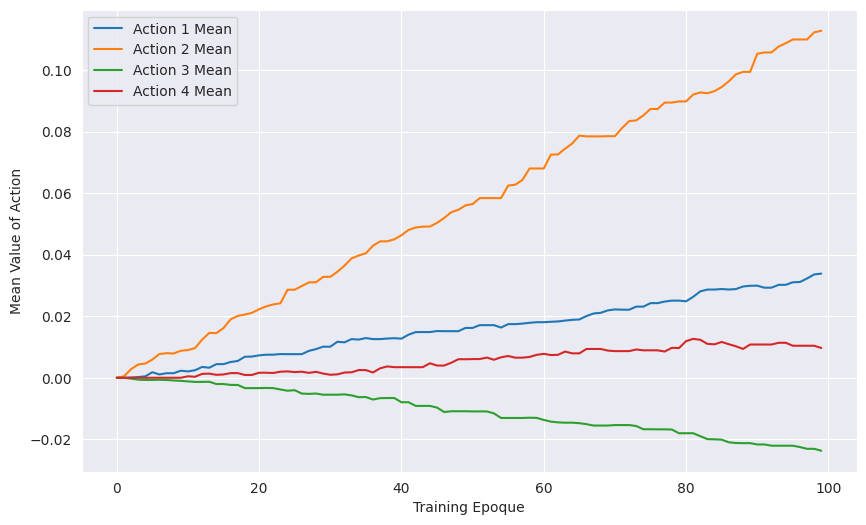

In [203]:

# Assuming q_table_list is a list of 100 Q-tables, each with shape (50, 4)
# For example: q_table_list[0].shape == (50, 4)

# Calculate the mean value of each action column for each Q-table
action_means = np.array([np.median(q_table, axis=0) for q_table in q_table_list])  # Shape: (100, 4)

# Create a plot
plt.figure(figsize=(10, 6))

# Plot the mean value of each action across all 100 Q-tables
for action_idx in range(action_means.shape[1]):  # There are 4 action columns
    plt.plot(action_means[:, action_idx], label=f'Action {action_idx + 1} Mean')

# Add labels, title, and legend
plt.xlabel('Training Epoque')
plt.ylabel('Mean Value of Action')

plt.legend()
plt.grid(True)
plt.savefig('/home/loz/MSc/MSc_Project/Write_Up/Charts/lit_basic_q_table.jpeg')
# Show the plot
plt.show()

In [184]:
action_means

array([[0.        , 0.00076337, 0.        , 0.        ],
       [0.        , 0.00076337, 0.        , 0.        ],
       [0.        , 0.00076337, 0.        , 0.        ]])

In [89]:
lit101_li

[[(array([[0.11]], dtype=float32), 0.12)],
 [(array([[0.94]], dtype=float32), 0.94)],
 [(array([[0.05]], dtype=float32), 0.02)],
 [(array([[0.2]], dtype=float32), 0.19)],
 [(array([[0.03]], dtype=float32), 0.06)],
 [(array([[0.02]], dtype=float32), 0.04)],
 [(array([[0.11]], dtype=float32), 0.09)],
 [(array([[0.57]], dtype=float32), 0.56)],
 [(array([[0.02]], dtype=float32), 0.03)],
 [(array([[0.09]], dtype=float32), 0.11)],
 [(array([[0.08]], dtype=float32), 0.05)],
 [(array([[0.11]], dtype=float32), 0.12)],
 [(array([[1.]], dtype=float32), 0.99)],
 [(array([[0.92]], dtype=float32), 0.91)],
 [(array([[0.04]], dtype=float32), 0.04)],
 [(array([[0.08]], dtype=float32), 0.08)],
 [(array([[0.09]], dtype=float32), 0.12)],
 [(array([[0.03]], dtype=float32), 0.05)],
 [(array([[0.12]], dtype=float32), 0.11)],
 [(array([[0.05]], dtype=float32), 0.07)],
 [(array([[0.13]], dtype=float32), 0.12)],
 [(array([[0.09]], dtype=float32), 0.07)],
 [(array([[0.12]], dtype=float32), 0.13)],
 [(array([[0.0

In [68]:
data = data[~np.all(data == 0, axis=1)]
data[-1]

array([0.        , 0.        , 0.00134365, 0.        ])

In [ ]:

max_indices = np.argmax(data, axis=1)

# Create x values scaled between 0 and 1
total_rows = len(data)  # Total number of rows in the data
x_values = np.linspace(0, 1, total_rows)  # Generate values from 0 to 1

plt.figure(figsize=(10, 6))
plt.scatter(x_values, max_indices)
plt.plot(x_values, max_indices)
plt.xlabel('State (max min scaled)')
plt.ylabel('Best Action')
plt.yticks(np.arange(data.shape[1])) 
plt.grid(True)
plt.legend()

plt.savefig('/home/loz/Documents/GitHub/MSc-Project/Write_Up/Charts/basic_q_best_action.jpeg')

# Show the plot
plt.show()

In [ ]:
q_table_list


In [ ]:
np.savez('/home/loz/Documents/GitHub/MSc-Project/final_code/component_objs/q_table_list_2000s.npz', *q_table_list) 

# Visualise Q Table COnvergence

In [ ]:
# Load the .npz file
file_path = '/home/loz/Documents/GitHub/MSc-Project/final_code/component_objs/q_table_list_2000s.npz'
data = np.load(file_path)

In [ ]:
# Find largest non zero array
max_rows, max_cols = 0, 0
for key in data.files:
    array = data[key]
    non_zero_indices = np.nonzero(array)
    if len(non_zero_indices[0]) > 0 and len(non_zero_indices[1]) > 0:
        max_row = max(non_zero_indices[0]) + 1
        max_col = max(non_zero_indices[1]) + 1
        if max_row > max_rows:
            max_rows = max_row
        if max_col > max_cols:
            max_cols = max_col

# Store the trimmed arrays
trimmed_arrays = {}

# Trim array 
for key in data.files:
    array = data[key]
    trimmed_array = array[:max_rows, :max_cols]
    trimmed_arrays[key] = trimmed_array

In [ ]:
data = trimmed_arrays

In [ ]:
data = trimmed_arrays
np.savez('/home/loz/Documents/GitHub/MSc-Project/final_code/component_objs/q_table_list_2000s.npz', data) 

In [ ]:
file_path = '/home/loz/Documents/GitHub/MSc-Project/final_code/component_objs/q_table_list_2000s.npz'
data = np.load(file_path, allow_pickle=True)

In [ ]:
data

In [ ]:

# best actions 
best_actions_list = []

for q_table in data.values():
    # get best action
    if isinstance(q_table, np.ndarray) and q_table.ndim == 2:
        best_actions = np.argmax(q_table, axis=1)
        best_actions_list.append(best_actions)
        
best_actions_array = np.array(best_actions_list)

# Calculate the mean and standard deviation 
mean_best_actions = np.mean(best_actions_array, axis=0)
std_best_actions = np.std(best_actions_array, axis=0)

# get rid of bins
x_values = (np.arange(len(mean_best_actions)) * 4) / 100

# Plot the mean best action
plt.figure(figsize=(12, 8))
plt.plot(x_values, mean_best_actions, label='Mean Best Action Index', color='blue', linewidth=2)

# Fill between mean and std 
plt.fill_between(x_values, 
                 mean_best_actions - std_best_actions, 
                 mean_best_actions + std_best_actions, 
                 color='blue', alpha=0.2, label='Standard Deviation')

# Customize the plot
#plt.title('General Trend of Best Actions')
plt.xlabel('State')
plt.ylabel('Best Action')
plt.yticks([0, 1, 2, 3])
plt.xlim(0, 1)
plt.legend(loc='best')
plt.grid(True)
plt.savefig('/home/loz/Documents/GitHub/MSc-Project/Write_Up/Charts/basic_q_best_action.jpeg')
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Extract the best actions from each Q-table and collect them into a list
best_actions_list = []

for q_table in data.values():
    if isinstance(q_table, np.ndarray) and q_table.ndim == 2:
        # Calculate the best action for each state (highest value in the row)
        best_actions = np.argmax(q_table, axis=1)
        best_actions_list.append(best_actions)

# Convert the list of best actions to a numpy array (shape: [num_q_tables, num_states])
best_actions_array = np.array(best_actions_list)

# Calculate the mean best action index across Q-tables for each state
mean_best_actions = np.mean(best_actions_array, axis=0)

# Plot the mean best action index over time
plt.figure(figsize=(12, 8))
plt.plot(mean_best_actions, label='Mean Best Action Index', color='blue', linewidth=2)

# Optionally, plot the median for a more robust trend line
median_best_actions = np.median(best_actions_array, axis=0)
plt.plot(median_best_actions, label='Median Best Action Index', color='orange', linestyle='--', linewidth=2)

# Customize the plot
plt.title('General Trend of Best Actions Across Q-Tables Over Time')
plt.xlabel('State (Time Step)')
plt.ylabel('Mean/Median Best Action Index')
plt.legend(loc='best')
plt.grid(True)
plt.show()


In [ ]:
q_table.shape

In [ ]:
# Set NumPy print options to display the full array
np.set_printoptions(threshold=np.inf)

In [ ]:
print(q_table)

In [ ]:
lit101_list = []
for _ in range(100):
    lit101_li,  q_table  = run_trial(SwatEnv,data_array,model_window,1)
    lit101_list.append(lit101_li)

In [ ]:
lit101_list

In [ ]:
lit101_list_ac1 = lit101_list.copy()

In [ ]:
lit101_list_ac5

In [ ]:
lit101_list

In [ ]:
self.lit101_value_record.

In [ ]:
input_windows.keys()

In [ ]:
trial_window = input_windows[0]

trial_window[0,-1,36]


In [ ]:
# final value for lit
for key,window in input_windows.items():
    print(window[0,-1,:][component_pos['LIT101']])

In [ ]:
#for key, value in values_dict.items():
#plt.plot(lit101_list_ac1, label=f'Episode {key}')
    #for item in value:
plt.plot(lit101_list, label='Action 1')
plt.plot(lit101_list, label= 'Action 5')

plt.xscale('log')
plt.xlabel('Time Steps')
plt.ylabel('LIT101 Level')
plt.title('LIT101 with MV101 On')
plt.legend(loc='lower right')
plt.savefig('/home/loz/Documents/GitHub/MSc-Project/Write_Up/Charts/MV101_held_high.jpeg')
#plt.savefig('/home/loz/Documents/GitHub/MSc-Project/Write_Up/Charts/LIT101_no_actions.jpeg')
plt.show()




# Create Deep Policy Table

# Create Deep Learning Model#

In [ ]:
states = env.observation_space.shape
actions = env.action_space.n

In [ ]:
states

In [ ]:
actions

In [ ]:
def build_model(states, actions):
    model = Sequential()    
    model.add(Dense(24, activation='relu', input_shape=states))
    #model.add(Dense(24, activation='relu', input_shape=(1,)))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    return model

In [ ]:
#del model

In [ ]:
model = build_model(states, actions)

In [ ]:
model.summary()

# Build Agent wit Keras-RL

In [ ]:
#@tf.function(reduce_retracing=True)
def build_agent(model, actions):
    policy = BoltzmannQPolicy()
    memory = SequentialMemory(limit=50000, window_length=1)
    dqn = DQNAgent(model=model, memory=memory, policy=policy,
                  nb_actions=actions, nb_steps_warmup=10, target_model_update=1e-2)
    return dqn

In [ ]:
dqn = build_agent(model, actions)

In [ ]:
dqn.compile(Adam(learning_rate=1e-3), metrics=['mae'])

In [ ]:


dqn.fit(env, nb_steps=5000, visualize=False, verbose=1)


In [ ]:
scores = dqn.test(env, nb_episodes=100, visualize=False)
print(np.mean(scores.history['episode_reward']))

In [ ]:
os.getcwd()

In [ ]:
#os.listdir()

In [ ]:
# get pre_trained model of SWaT
swat_lstm = tf.keras.models.load_model('swat_lstm_100s.keras')
